In [10]:
# Imports
import numpy as np
import pandas as pd
import re
import seaborn as sns
import scipy
import contractions
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# Reading CSV File into Pandas DataFrame
df = pd.read_csv('Data/IMDB Dataset.csv',
                 nrows = 1000)
df['review'] = df['review'].str.lower()
df['sentiment'] = df['sentiment'].str.replace('none', '')
df['sentiment'] = df['sentiment'].fillna('')
print('Data Set Size:', df.shape)

Data Set Size: (1000, 2)


In [31]:
# Label Encoding
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
# print(df['sentiment'])
count = df['sentiment'].value_counts()
print(count)
print(type(count))

1    501
0    499
Name: sentiment, dtype: int64
<class 'pandas.core.series.Series'>


In [4]:
# Tokemization
def tokenize(text):
    return [i.text for i in tokenizer(text)]

# Text Lemmatization
def lemmatization(text):
    doc = nlp(text)
    temp_list = []
    for token in doc:
        temp_list.append(token)
    return ' '.join(map(str, temp_list))

# Stop Word Removal
def stopword_removal(text):
    temp_list = []
    for item in tokenize(text):
        if item not in stopwords:
            temp_list.append(item)
    return ' '.join(temp_list)

In [5]:
# Pre-Process Text
def preprocess_text(text):
    # Removing all HTML Tags
    text = re.sub(r'<.*?>', '', text)
    # Removing links
    text = re.sub(r'http\S+', '', text)
    # Remove Text Contractions
    text = contractions.fix(text)
    # Removing special characters and numbers
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    # Lemmatization
    text = lemmatization(text)
    # Stop word Removal
    text = stopword_removal(text)
    # Removing single characters
    text = re.sub(r's+[a-zA-Z]s+', '', text)
    # Replacing multi-spaces by a single space
    text = re.sub(r'\s+', ' ', text)
    return text

In [8]:
x = df['review']
x_corpus = []
for idx, row in x.items():
    sentence = preprocess_text(row)
    x_corpus.append(sentence)

y = df['sentiment']

# Fit Count Vectorizer to Data set
def c_vectorize(x):
    vectorizer = CountVectorizer(ngram_range = (1, 2), 
                                 min_df = 2)
    return vectorizer.fit_transform(x)

x_vector_cv = c_vectorize(x_corpus)
print(x_vector_cv.shape)

# Fit Tf-Idf Vectorizer to Data set
def ti_vectorize(x):
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), 
                                 min_df = 2)
    return vectorizer.fit_transform(x)

x_vector_tfidf = ti_vectorize(x_corpus)
print(x_vector_tfidf.shape)

(1000, 13131)
(1000, 13131)


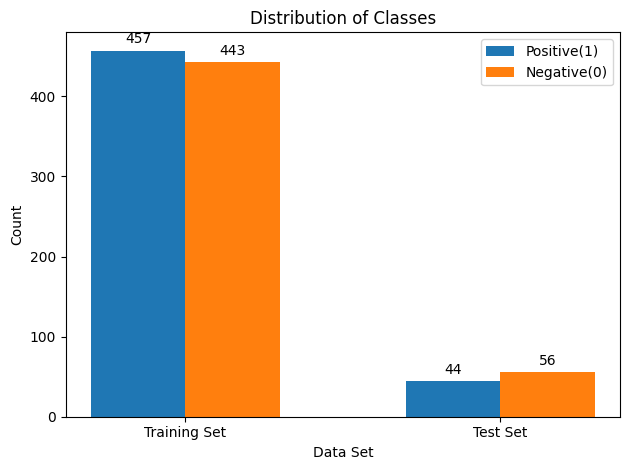

In [9]:
# Splitting the dataset into the Training set and Validation set
np.random.seed(32)
x_train, x_test, y_train, y_test = train_test_split(x_vector_cv, 
                                                    y, 
                                                    random_state = 0, 
                                                    test_size = 0.1, 
                                                    shuffle = True)

# Class Disribution in the Dataset
def class_distribution(data):
    count = df['sentiment'].value_counts()
print(count)

y_train_positive,  y_train_negative = class_distribution(y_train)
y_test_positive,  y_test_negative = class_distribution(y_test)
        
# Plot of Class Disribution in the Dataset    
labels = ['Training Set', 'Test Set']
positive = [y_train_positive, y_test_positive]
negative = [y_train_negative, y_test_negative]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, 
                positive, 
                width, 
                label='Positive(1)')
rects2 = ax.bar(x + width/2, 
                negative, 
                width, 
                label='Negative(0)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Data Set')
ax.set_title('Distribution of Classes')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [20]:
# Truncated SVD for Dimensionality Reduction
def truncated_svd(x):
    tsvd = TruncatedSVD(n_components = 50)
    tsvd_fit = tsvd.fit_transform(x)
    return tsvd_fit
    
x_vector_cv_svd = truncated_svd(x_vector_cv)
x_vector_tfidf_svd = truncated_svd(x_vector_tfidf)

In [21]:
# K-Fold Cross Validation
k_fold = KFold(n_splits = 10, 
               random_state = 0, 
               shuffle = True)

In [22]:
# Applying SVM to Training Text
def svm_classifier_kfold(x, 
                         y):
    clf_svm = svm.SVC(kernel = 'linear')
    clf_svm.fit(x, y)
    results = cross_val_score(clf_svm,
                             x,
                             y,
                             cv = k_fold)
    return results, results.mean()    

In [23]:
# Applying Naive Bayes to Training Text
def nb_classifier_kfold(x, 
                        y):
    clf_nb = BernoulliNB(alpha = 1 , 
                     binarize = 0.0 , 
                     fit_prior = False , 
                     class_prior = None)
    clf_nb.fit(x, y)  
    results = cross_val_score(clf_nb,
                         x,
                         y,
                         cv = k_fold)
    return results, results.mean()

In [28]:
# Results: SVM
print('Count Vec + SVM: ', svm_classifier_kfold(x_vector_cv, y))
print('Count Vec + SVD + SVM: ', svm_classifier_kfold(x_vector_cv_svd, y))
print('TF-IDF + SVM: ', svm_classifier_kfold(x_vector_tfidf, y))
print('TF-IDF + SVD + SVM: ', svm_classifier_kfold(x_vector_tfidf_svd, y))

print('_________________________________________________________________________________________________________________')

# Results: Naive Bayes
print('Count Vec + NB: ', nb_classifier_kfold(x_vector_cv, y))
print('Count Vec + SVD + NB: ', nb_classifier_kfold(x_vector_cv_svd, y))
print('TF-IDF + NB: ', nb_classifier_kfold(x_vector_tfidf, y))
print('TF-IDF + SVD + NB: ', nb_classifier_kfold(x_vector_tfidf_svd, y))

Count Vec + SVM:  (array([0.82, 0.85, 0.9 , 0.8 , 0.83, 0.81, 0.76, 0.87, 0.78, 0.76]), 0.8180000000000002)
Count Vec + SVD + SVM:  (array([0.76, 0.73, 0.78, 0.72, 0.81, 0.69, 0.7 , 0.72, 0.73, 0.72]), 0.736)
TF-IDF + SVM:  (array([0.8 , 0.8 , 0.9 , 0.77, 0.92, 0.79, 0.8 , 0.81, 0.75, 0.79]), 0.813)
TF-IDF + SVD + SVM:  (array([0.8 , 0.8 , 0.9 , 0.77, 0.92, 0.79, 0.8 , 0.81, 0.75, 0.79]), 0.813)
_________________________________________________________________________________________________________________
Count Vec + NB:  (array([0.8 , 0.84, 0.86, 0.83, 0.85, 0.84, 0.72, 0.71, 0.75, 0.71]), 0.791)
Count Vec + SVD + NB:  (array([0.75, 0.69, 0.77, 0.71, 0.65, 0.69, 0.59, 0.69, 0.68, 0.69]), 0.6909999999999998)
TF-IDF + NB:  (array([0.79, 0.72, 0.82, 0.73, 0.79, 0.66, 0.76, 0.68, 0.65, 0.73]), 0.733)
TF-IDF + SVD + NB:  (array([0.79, 0.72, 0.82, 0.73, 0.79, 0.66, 0.76, 0.68, 0.65, 0.73]), 0.733)
